In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [5]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [6]:
x.size()

torch.Size([1, 4, 512])

In [10]:
qkv_layer = nn.Linear(input_dim, 3* d_model)
qkv = qkv_layer(x)
qkv.size()

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

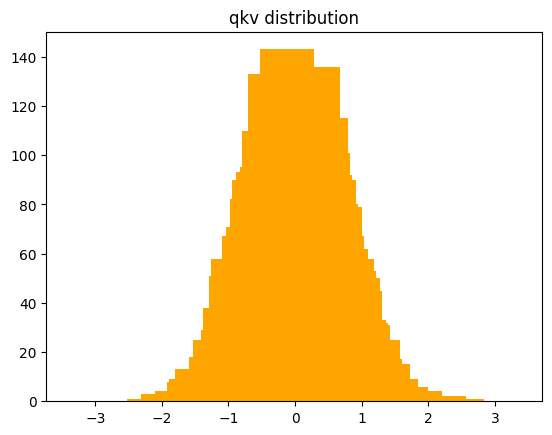

In [11]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min = -3, max = 3)
x_val = np.arange(-1,1,0.01) * 3
plt.bar(x_val, y_val, align = "center", color =['orange']) 
plt.title('qkv distribution')

In [18]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [20]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [21]:
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

Self attention for multiple heads

for a single head : 

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>self attention</mtext>
  <mo>=</mo>
  <mi>s</mi>
  <mi>o</mi>
  <mi>f</mi>
  <mi>t</mi>
  <mi>m</mi>
  <mi>a</mi>
  <mi>x</mi>
  <mrow data-mjx-texclass="ORD">
    <mo minsize="2.047em" maxsize="2.047em">(</mo>
  </mrow>
  <mfrac>
    <mrow>
      <mi>Q</mi>
      <mo>.</mo>
      <msup>
        <mi>K</mi>
        <mi>T</mi>
      </msup>
    </mrow>
    <msqrt>
      <msub>
        <mi>d</mi>
        <mi>k</mi>
      </msub>
    </msqrt>
  </mfrac>
  <mo>+</mo>
  <mi>M</mi>
  <mrow data-mjx-texclass="ORD">
    <mo minsize="2.047em" maxsize="2.047em">)</mo>
  </mrow>
</math>

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>new V</mtext>
  <mo>=</mo>
  <mtext>self attention</mtext>
  <mo>.</mo>
  <mi>V</mi>
</math>

In [24]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [25]:
k.shape, k.T.shape

(torch.Size([1, 8, 4, 64]), torch.Size([64, 4, 8, 1]))

In [30]:
y = torch.randn(2, 3)

In [27]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [28]:
(scaled+mask)[0][0]

tensor([[-1.1822e-01,        -inf,        -inf,        -inf],
        [ 1.2753e-01,  1.8514e-01,        -inf,        -inf],
        [-3.8797e-04, -5.4900e-02,  8.5396e-02,        -inf],
        [-6.6785e-02,  5.2861e-01, -6.3264e-02,  1.9720e-01]],
       grad_fn=<SelectBackward0>)

In [29]:
scaled += mask

In [31]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.404))

0.5388217044001664

In [32]:
attention = F.softmax(scaled, dim = -1)

attention.shape

torch.Size([1, 8, 4, 4])

In [35]:
import math

def scaled_dot_product(q, k, v, mask = None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask.any():
        scaled += mask
    
    attention = F.softmax(scaled, dim = -1)
    values = torch.matmul(attention, v)
    return values, attention

In [36]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [37]:
values.shape

torch.Size([1, 8, 4, 64])

In [38]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [39]:
linear_layer = nn.Linear(d_model, d_model)

out = linear_layer(values)

In [41]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [42]:

input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
